In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import pickle

In [2]:
def tensor_imshow(im_tensor,cannel):
    b,c,h,w=im_tensor.shape
    if c==1:
        plt.imshow(im_tensor.squeeze().detach().numpy())
    else:
        plt.imshow(im_tensor.squeeze().detach().numpy()[cannel,:])

def get_training_fragment(frag_size,im):
    h,w,c=im.shape
    n=random.randint(0,int(h-frag_size-1))
    m=random.randint(0,int(w-frag_size-1))
    
    vt_h=math.ceil((h+1)/8)
    vt_w=math.ceil((w+1)/8)
    vt=np.zeros([vt_h,vt_w])
    vt_h_po=round((vt_h-1)*(2*n+frag_size)/(2*(h-1)))
    vt_w_po=round((vt_w-1)*(2*m+frag_size)/(2*(w-1)))
    vt[vt_h_po,vt_w_po]=1
    vt = np.float32(vt)
    vt=torch.from_numpy(vt.reshape(1,1,vt_h,vt_w))
    
    return im[n:n+frag_size,m:m+frag_size,:],vt

def img2tensor(im):
    im=np.array(im,dtype="float32")
    tensor_cv = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im_tensor=tensor_cv.unsqueeze(0)
    return im_tensor

def show_coordonnee(position_pred):
    map_corre=position_pred.squeeze().detach().numpy()
    h,w=map_corre.shape
    max_value=map_corre.max()
    coordonnee=np.where(map_corre==max_value)
    return coordonnee
    """
    if len(coordonnee[0])==1:
        h_=coordonnee[0][0]/h
        w_=coordonnee[1][0]/w
        return max_value,h_,w_
    else:
        return -1,-1,-1
    """
def save_net(file_path,net):
    pkl_file = open(file_path, 'wb')
    pickle.dump(net,pkl_file)
    pkl_file.close()
    
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

In [6]:
def kernel_add_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n/2)*int(m/2)
    for i in range(int(n/2)):
        for j in range(int(m/2)):
            kernel_add=np.zeros([1,input_canal],dtype='float32')
            kernel_add[0,i*2*m+j*2]=1
            kernel_add[0,i*2*m+j*2+1]=1
            kernel_add[0,(i*2+1)*m+j*2]=1
            kernel_add[0,(i*2+1)*m+j*2+1]=1
            if i==0 and j==0:
                add=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
            else:
                add_=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
                add=torch.cat((add,add_),0)
    return torch.nn.Parameter(add,requires_grad=False) 

def kernel_shift_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n*m)
    
    kernel_shift=torch.zeros([output_canal,input_canal,3,3])
    
    array_0=np.array([[1,0,0],[0,0,0],[0,0,0]],dtype='float32')
    array_1=np.array([[0,0,1],[0,0,0],[0,0,0]],dtype='float32')
    array_2=np.array([[0,0,0],[0,0,0],[1,0,0]],dtype='float32')
    array_3=np.array([[0,0,0],[0,0,0],[0,0,1]],dtype='float32')
    
    kernel_shift_0=torch.from_numpy(array_0)
    kernel_shift_1=torch.from_numpy(array_1)
    kernel_shift_2=torch.from_numpy(array_2)
    kernel_shift_3=torch.from_numpy(array_3)
    
    
    for i in range(n):
        for j in range(m):
            if i==0 and j==0:
                kernel_shift[0,0,:]=kernel_shift_0
            else:
                if i%2==0 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_0
                if i%2==0 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_1
                if i%2==1 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_2
                if i%2==1 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_3
                    
    return torch.nn.Parameter(kernel_shift,requires_grad=False) 

def get_patch(fragment,psize,n,m):
    return fragment[:,:,n*psize:(n+1)*psize,m*psize:(m+1)*psize]

def shift_1pixel(map_corr,num_patch):
    #num_patch:
    #          0 1
    #          2 3
    h,w=map_corr.shape
    map_shifted=torch.zeros([h,w])
    if num_patch==0:
        map_shifted[1:h,1:w]=map_corr[0:h-1,0:w-1]
    if num_patch==1:
        map_shifted[1:h,0:w-1]=map_corr[0:h-1,1:w]
    if num_patch==2:
        map_shifted[0:h-1,1:w]=map_corr[1:h,0:w-1]
    if num_patch==3:
        map_shifted[0:h-1,0:w-1]=map_corr[1:h,1:w]
        
    return map_shifted

def shift_map_corre(n,m,map_corre):
    b,c,h,w=map_corre.shape
    for i in range(n):
        for j in range(m):
            if i%2==0 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],0)
            if i%2==0 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],1)
            if i%2==1 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],2)
            if i%2==1 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],3)
    return map_corre

class Net(nn.Module):
    def __init__(self,frag_size,psize):
        super(Net, self).__init__()
       
        h_fr=frag_size
        w_fr=frag_size
        
        n=int(h_fr/psize) #n*m patches
        m=int(w_fr/psize)
        
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1)
        #self.conv1.weight=ini()
        self.Relu = nn.ReLU(inplace=False)
        self.maxpooling=nn.MaxPool2d(3,stride=2, padding=1)
        
        self.shift1=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift1.weight=kernel_shift_ini(n,m)
        self.add1 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add1.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        self.shift2=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift2.weight=kernel_shift_ini(n,m)
        self.add2 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add2.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        self.shift3=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift3.weight=kernel_shift_ini(n,m)
        self.add3 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add3.weight=kernel_add_ini(n,m)
        
        self.reform=nn.Linear(in_features = 21*41, out_features = 21*41)
        
    def get_descripteur(self,img,using_cuda):
        descripteur_img=self.Relu(self.conv1(img))
        b,c,h,w=descripteur_img.shape
        couche_constante=0.5*torch.ones([1,1,h,w])
        if using_cuda:
            couche_constante_cuda=couche_constante.cuda()
            descripteur_img=torch.cat((descripteur_img,couche_constante_cuda),1)
        else:
            descripteur_img=torch.cat((descripteur_img,couche_constante),1)
        descripteur_img_norm=descripteur_img/torch.norm(descripteur_img,dim=1)
        return descripteur_img_norm
    
    def forward(self,img,frag,using_cuda):
        psize=4
        
        descripteur_input1=self.get_descripteur(img,using_cuda)
        descripteur_input2=self.get_descripteur(frag,using_cuda)
        
        b,c,h,w=frag.shape
        n=int(h/psize)
        m=int(w/psize)
        
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    map_corre=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                else:
                    a=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                    map_corre=torch.cat((map_corre,a),1)
        #shift
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift1(map_corre)
        map_corre=self.add1(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift2(map_corre)
        map_corre=self.add2(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift3(map_corre)
        map_corre=self.add3(map_corre)
        
        
        b,c,h,w=map_corre.shape
        map_corre=map_corre/(map_corre.max())
        return map_corre

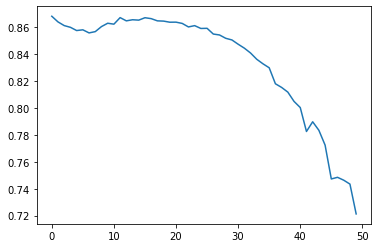

In [8]:
if __name__=='__main__':
    psize=4
    frag_size=32
    using_cuda=False
    torch.cuda.empty_cache()
    
    
    net=Net(frag_size,psize)
    optimizer = torch.optim.Adamax(net.parameters())
    loss_func = torch.nn.MSELoss()
    loss_value=[]
    
    
    im_path="./lenna.png"
    img_training=cv2.imread(im_path)
    im_tensor=img2tensor(img_training)
    
    
    if using_cuda:
        net=net.cuda()
        loss_func_cuda=loss_func.cuda()
        im_tensor=im_tensor.cuda()
        
    for i in range(50):
        frag,vt=get_training_fragment(frag_size,img_training)
        frag_tensor=img2tensor(frag)
        if using_cuda:
            vt=vt.cuda()
            frag_tensor=frag_tensor.cuda()
        frag_pred=net.forward(im_tensor,frag_tensor,using_cuda)
        b,c,h,w=vt.shape
                
        err_=loss_func_cuda(vt,frag_pred)
                
        optimizer.zero_grad()
        err_.backward(retain_graph=True)
                    
        optimizer.step()
        loss_value.append(err_.tolist())
                
    plt.plot(loss_value)